In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D
from lmfit.models import LinearModel

# set font to 15
mpl.rcParams.update({'font.size': 9})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [3]:
rg_listing = read_sql(
    """
    SELECT
        pr.temperature,
        c.disp_name AS construct_name,
        n.site,

        MAX(CASE WHEN pr.replicate = 1 THEN pr.rg_id END) AS rg_id_rep1,
        MAX(CASE WHEN pr.replicate = 2 THEN pr.rg_id END) AS rg_id_rep2,
        MAX(CASE WHEN pr.replicate = 3 THEN pr.rg_id END) AS rg_id_rep3,
        MAX(CASE WHEN pr.replicate = 4 THEN pr.rg_id END) AS rg_id_rep4

    FROM probe_reactions pr
    JOIN probe_reaction_groups prg
        ON prg.rg_id = pr.rg_id
    LEFT JOIN probe_fmod_values fv
        ON fv.rxn_id = pr.id
    JOIN meta_nucleotides n
        ON n.id = fv.nt_id
    JOIN meta_constructs c
        ON c.id = pr.construct_id

    WHERE fv.valtype IS NOT NULL
    AND fv.fmod_val IS NOT NULL

    GROUP BY
        pr.temperature,
        c.disp_name,
        n.site

    ORDER BY
        pr.temperature,
        c.disp_name,
        n.site;
    """
)

rg_listing

,temperature,construct_name,site,rg_id_rep1,rg_id_rep2,rg_id_rep3,rg_id_rep4
0,10.0,4U_wt,1,51.0,52.0,NaN,NaN
1,10.0,4U_wt,2,51.0,52.0,NaN,NaN
2,10.0,4U_wt,3,51.0,52.0,NaN,NaN
3,10.0,4U_wt,4,51.0,52.0,NaN,NaN
4,10.0,4U_wt,5,51.0,52.0,NaN,NaN
...,...,...,...,...,...,...,...
2294,85.0,4U_wt,34,15.0,NaN,NaN,NaN
2295,85.0,4U_wt,35,15.0,NaN,NaN,NaN
2296,85.0,4U_wt,36,15.0,NaN,NaN,NaN
2297,85.0,4U_wt,61,15.0,NaN,NaN,NaN


In [4]:
replicate_cols = ["rg_id_rep1","rg_id_rep2","rg_id_rep3","rg_id_rep4"]
r2_thresh = 0.5

long = (
    rg_listing
    .reset_index(drop=True)
    .reset_index(names="row_id")
    .melt(
        id_vars=["row_id", "site", "construct_name"],
        value_vars=replicate_cols,
        var_name="rep_col",
        value_name="rg_id",
    )
    .dropna(subset=["rg_id"])
)

long["rg_id"] = long["rg_id"].astype(int)

pairs = long[["rg_id","site","construct_name"]].drop_duplicates()

if pairs.empty:
    # nothing to query; just add empty cols
    replicate_df = rg_listing.copy()
    for k in ["kobs_rep1","kobs_rep2","kobs_rep3","kobs_rep4"]:
        replicate_df[k] = np.nan
else:
    placeholders = ",".join(["(?,?,?)"] * len(pairs))
    params = pairs.to_numpy().ravel().tolist()   # <-- robust flatten

    sql = f"""
    WITH targets(rg_id, site, construct_name) AS (
      VALUES {placeholders}
    ),

    nt AS (
      SELECT t.rg_id, mn.id AS nt_id
      FROM targets t
      JOIN meta_constructs mc ON mc.disp_name = t.construct_name
      JOIN meta_nucleotides mn ON mn.site = t.site
    ),

    runs AS (
      SELECT r.id AS fit_run_id, r.rg_id, r.nt_id
      FROM probe_tc_fit_runs r
      JOIN nt ON nt.rg_id = r.rg_id AND nt.nt_id = r.nt_id
      WHERE r.fit_kind = 'round3_constrained'
        AND r.valtype   = 'modrate'
    ),

    r2_filtered AS (
      SELECT
        p.fit_run_id,
        MAX(p.param_numeric) AS diag_r2
      FROM probe_tc_fit_params p
      WHERE p.param_name = 'diag:r2'
      GROUP BY p.fit_run_id
      HAVING diag_r2 >= ?
    )

    SELECT
      runs.rg_id,
      mn.site,
      mc.disp_name AS construct_name,

      MAX(CASE
            WHEN p.param_name IN ('log_kobs','logkobs')
            THEN p.param_numeric
          END) AS log_kobs,

      MAX(CASE
            WHEN p.param_name = 'diag:r2'
            THEN p.param_numeric
          END) AS diag_r2

    FROM runs
    JOIN r2_filtered rf
      ON rf.fit_run_id = runs.fit_run_id
    JOIN probe_tc_fit_params p
      ON p.fit_run_id = runs.fit_run_id
    JOIN meta_nucleotides mn
      ON mn.id = runs.nt_id
    JOIN probe_reactions pr
      ON pr.rg_id = runs.rg_id
    JOIN meta_constructs mc
      ON mc.id = pr.construct_id

    GROUP BY
      runs.rg_id,
      mn.site,
      mc.disp_name;
    """

    # IMPORTANT: append r2_thresh as the final positional binding
    kobs_map = read_sql(sql, params + [r2_thresh])

    long2 = long.merge(
        kobs_map,
        on=["rg_id","site","construct_name"],
        how="left",
    )

    kobs_wide = (
        long2.pivot(index="row_id", columns="rep_col", values="log_kobs")
        .rename(columns={
            "rg_id_rep1":"kobs_rep1",
            "rg_id_rep2":"kobs_rep2",
            "rg_id_rep3":"kobs_rep3",
            "rg_id_rep4":"kobs_rep4",
        })
    )

    replicate_df = (
        rg_listing
        .reset_index(drop=True)
        .join(kobs_wide, how="left")
    )

In [5]:
replicate_df

,temperature,construct_name,site,rg_id_rep1,rg_id_rep2,rg_id_rep3,rg_id_rep4,kobs_rep1,kobs_rep2,kobs_rep3,kobs_rep4
0,10.0,4U_wt,1,51.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,4U_wt,2,51.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,4U_wt,3,51.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,4U_wt,4,51.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,4U_wt,5,51.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2294,85.0,4U_wt,34,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2295,85.0,4U_wt,35,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2296,85.0,4U_wt,36,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297,85.0,4U_wt,61,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


R-squared: 0.871


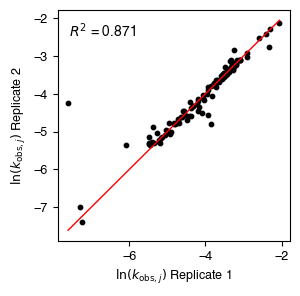

In [6]:
replicate_df_4U = replicate_df[replicate_df['construct_name'].str.contains('4U_wt')]
# filter to sites in 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
replicate_df_4U = replicate_df_4U[replicate_df_4U['site'].isin([7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35])].dropna(subset=['kobs_rep1', 'kobs_rep2'])

# filter log_kobs_rep1 greater then -10
replicate_df_4U = replicate_df_4U[replicate_df_4U['kobs_rep1'] > -10]

fig, ax = plt.subplots(figsize=(3, 3))
replicate_df_4U.plot(
    x='kobs_rep1',
    y='kobs_rep2',
    kind='scatter',
    ax=ax,
    xlabel=r'$\ln(k_{\text{obs},j})$ Replicate 1',
    ylabel=r'$\ln(k_{\text{obs},j})$ Replicate 2',
    grid=False,
    color='black',
    s = 10
)

# draw y=x line
min_val = min(replicate_df_4U['kobs_rep1'].min(), replicate_df_4U['kobs_rep2'].min())
max_val = max(replicate_df_4U['kobs_rep1'].max(), replicate_df_4U['kobs_rep2'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=1)

# calculate R2 on y=x line
slope, intercept = np.polyfit(replicate_df_4U['kobs_rep1'], replicate_df_4U['kobs_rep2'], 1)
r_value = np.corrcoef(replicate_df_4U['kobs_rep1'], replicate_df_4U['kobs_rep2'])[0, 1]
r_squared = r_value**2
print(f"R-squared: {r_squared:.3f}")

# Annotate R2 on plot
ax.text(0.05, 0.95, f'$R^2$ = {r_squared:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
plt.savefig('SFig5_4U_WT_replicate_reproducibility.pdf', bbox_inches='tight')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


R-squared: 0.919


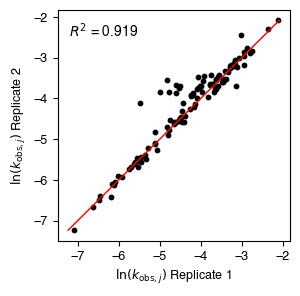

In [7]:
replicate_df_4U = replicate_df[replicate_df['construct_name'].str.contains('4U_a8c')]
# filter to sites in 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
replicate_df_4U = replicate_df_4U[replicate_df_4U['site'].isin([7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35])].dropna(subset=['kobs_rep1', 'kobs_rep2'])

# filter log_kobs_rep1 greater then -10
replicate_df_4U = replicate_df_4U[replicate_df_4U['kobs_rep1'] > -10]

fig, ax = plt.subplots(figsize=(3, 3))
replicate_df_4U.plot(
    x='kobs_rep1',
    y='kobs_rep2',
    kind='scatter',
    ax=ax,
    xlabel=r'$\ln(k_{\text{obs},j})$ Replicate 1',
    ylabel=r'$\ln(k_{\text{obs},j})$ Replicate 2',
    grid=False,
    color='black',
    s = 10
)

# draw y=x line
min_val = min(replicate_df_4U['kobs_rep1'].min(), replicate_df_4U['kobs_rep2'].min())
max_val = max(replicate_df_4U['kobs_rep1'].max(), replicate_df_4U['kobs_rep2'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=1)

# calculate R2 on y=x line
slope, intercept = np.polyfit(replicate_df_4U['kobs_rep1'], replicate_df_4U['kobs_rep2'], 1)
r_value = np.corrcoef(replicate_df_4U['kobs_rep1'], replicate_df_4U['kobs_rep2'])[0, 1]
r_squared = r_value**2
print(f"R-squared: {r_squared:.3f}")

# Annotate R2 on plot
ax.text(0.05, 0.95, f'$R^2$ = {r_squared:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
plt.savefig('SFig5_4U_A8C_replicate_reproducibility.pdf', bbox_inches='tight')
plt.show()